# Baseline Model Experiment 

This notebook contains a baseline model experiment with a simple Artificial Neural Network (ANN) using [FastAI Tabular Learner](https://docs.fast.ai/tabular.learner.html). We begin experiments with this simple model on the premise that - when taking into account the level of effort - clever feature engineering typically outperforms employing alternative model types (such as using LSTMs). 

A few items about the experiment: 

- We train for `D` days (periods) and predict on the next day in order to train the model. After each complete period, the model is retrained on the new data (either from scratch or with transfter learning). We model the experiment this way to coincide with how a model would be used in practice and to account for the fast that the most recent data has an outsized influence on model performance. 
- We identify and utilize periods of observations for model training and testing that are greater than some threshold `period_size`. Deep neural networks cannot be trained with missing data. 
- Related to the above, it would be an inappropriate training strategy to simply concatenate the periods together during the training process - the value(s) at the end of a period does not help predict the values at the beginning of the next period. As such, we will need to retrain the model for each subsequent day in the training set using transfer learning. The same testing set is used throughout the model training process. 
- An appropriate learning rate is determined using an automated learning rate finder. 
- The model is trained using an early stopping criterion that is intened to ovoid model overfitting. 
- A selection of possible model architectures for the ANN (nodes in the layers, drop out rates, etc). is available for the experiments. 

## Imports 

In [ ]:
import sys; sys.executable

In [225]:
from fastai.tabular import *
from fastai.metrics import *
from fastai import torch_core
from fastai.callbacks import *
from fastai.callbacks.mem import PeakMemMetric
from fastai.utils.mod_display import *

import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import seaborn as sns
from scipy import stats
from src import data
import torch
from tqdm.notebook import tqdm

## Experiment Parameters

In [52]:
architectures = {
    1: {
        "layers": [10, 500, 1000, 2500, 25000, 2500, 1000, 500, 10],
        "ps": [0.0, 0.1, 0.2, 0.2, 0.25, 0.2, 0.2, 0.1, 0.0]
    },
    2: {
        "layers": [10, 50, 100, 250, 1000, 250, 100, 50, 10],
        "ps": [0.5, 0.4, 0.3, 0.2, 0.2, 0.1, 0.05, 0.025, 0.0]
    },
    3: {
        "layers": [10, 50, 100, 250, 1000, 250, 100, 50, 10],
        "ps": [0.0, 0.025, 0.05, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5]
    },
    4: {
        "layers": [50000, 5000, 1000, 500, 25, 1],
        "ps": [0.2, 0.15, 0.1, 0.05, 0.025, 0.]
    },
    5: {
        "layers": [50000, 7500, 2500, 1000, 250, 80, 25, 1],
        "ps": [0.25, 0.2, 0.15, 0.1, 0.05, 0.025, 0.01, 0]
    }
}

In [53]:
# data 
YEAR = 2012 # can be 2012, 2015
LOCATION = "hawaii" # can be hawaii, chile
DATA_PATHS = Path('../data/' + LOCATION + '/' + str(YEAR))
DAYS = [str(f).split("/")[-1] for f in DATA_PATHS.iterdir() if f.is_dir()]
GROUND_STATION = "ahup" # string
SAT = "G08" # string
ELE_FILTER = 15 # int or None
TIME_AGG = "1Min"

# model specification 
MODEL_SAVE_DIR = ""
MODEL_NAME = "model-latest"
if MODEL_SAVE_DIR == "":
    MODEL_LOCATION = MODEL_NAME
else:
    MODEL_LOCATION = MODEL_SAVE_DIR + "/" + MODEL_NAME
MODEL_ARCHITECTURE = 5
BATCH_SIZE = 16
DEP = GROUND_STATION + "__" + SAT
FEATURES = [
#     GROUND_STATION + "__" + SAT,
    GROUND_STATION + "__" + SAT + "_ele",
    GROUND_STATION + "__" + SAT + "_lat",
    GROUND_STATION + "__" + SAT + "_lon",
    GROUND_STATION + "__" + SAT + "_h_ipp"
]
MAX_EPOCHS = 500

## Select a CUDA Device

In [54]:
torch.cuda.is_available()

True

In [55]:
torch.cuda.device_count()

4

In [56]:
DEVICE = 3

In [57]:
torch.cuda.set_device(DEVICE)

In [58]:
cuda_device = torch.device('cuda:' + str(DEVICE))

In [59]:
torch.cuda.current_device()

3

One useful command for monitoring GPU utilization is one from `nvidia-smi`:

```bash
nvidia-smi -q -g 0 -d UTILIZATION -l
```

Or: 

```bash
gpustat -cp -i 1
```

## Read Data

This experiment uses data from the Hawaii dataset. We will train the model on a period of `D` days (periods) and test on the latest day (period). The day of the earthquake will represent the _validation_ set, data that is unseen during the model training process. 

In [60]:
dataframes = dict()
for d in DAYS:
    print("\n--- " + str(d) + "---")
    
    # read in the data 
    df = data.read_day(
        location=LOCATION,
        year=YEAR,
        day_of_year=int(d)
    )
    dataframes[d] = df

  0%|          | 3/1595 [00:00<01:00, 26.40it/s]


--- 300---
Reading dataframes...


100%|██████████| 1595/1595 [00:50<00:00, 31.56it/s]


Concatenating dataframes...


  0%|          | 4/1596 [00:00<00:45, 34.63it/s]


--- 301---
Reading dataframes...


100%|██████████| 1596/1596 [00:54<00:00, 29.04it/s]


Concatenating dataframes...


  0%|          | 4/1597 [00:00<00:46, 34.27it/s]


--- 302---
Reading dataframes...


100%|██████████| 1597/1597 [00:51<00:00, 31.18it/s]


Concatenating dataframes...


  0%|          | 4/1597 [00:00<00:45, 34.78it/s]


--- 303---
Reading dataframes...


100%|██████████| 1597/1597 [00:57<00:00, 27.99it/s]


Concatenating dataframes...


  0%|          | 4/1596 [00:00<00:52, 30.57it/s]


--- 304---
Reading dataframes...


100%|██████████| 1596/1596 [00:54<00:00, 29.51it/s]


Concatenating dataframes...


In [61]:
# concatenate the dataframes loaded previously into one large dataframe 
df_all = pd.concat([dataframes[d] for d in dataframes.keys()]) 

## Prep Dataset

The above experimental parameter definitions will be interesting to explore. However, we also need to be smart about which data we feed into the model for training and how to feet that data into the model as well in order to set a good baseline for our experiments. 

The data contains missing values and - in practice and in the real-world - and we'll need to account for that in our modeling strategy. We'll want to train the model on each chunk of data to come in, and a chunk represents a continuous stretch of data without any missing values. 

In [62]:
df_sat = df_all.filter(regex=GROUND_STATION + "__" + SAT, axis=1)

In [63]:
df_sat.head()

ahup__G08  ahup__G08_lon  ahup__G08_lat  ahup__G08_h_ipp  \
timestamp                                                                       
2012-10-26 00:00:15        NaN            NaN            NaN              NaN   
2012-10-26 00:00:30        NaN            NaN            NaN              NaN   
2012-10-26 00:00:45        NaN            NaN            NaN              NaN   
2012-10-26 00:01:00        NaN            NaN            NaN              NaN   
2012-10-26 00:01:15        NaN            NaN            NaN              NaN   

                     ahup__G08_ele  ahup__G08_azi  
timestamp                                          
2012-10-26 00:00:15            NaN            NaN  
2012-10-26 00:00:30            NaN            NaN  
2012-10-26 00:00:45            NaN            NaN  
2012-10-26 00:01:00            NaN            NaN  
2012-10-26 00:01:15            NaN            NaN

In [64]:
df_sat.shape

(28804, 6)

### Elevation Filter 

Exclude any observations recorded below a specific elevation specified. 

In [65]:
if ELE_FILTER is not None: 
    df_sat = df_sat[df_sat[GROUND_STATION + "__" + SAT + "_ele"] > ELE_FILTER]

In [66]:
df_sat.shape

(3845, 6)

### Resample

In [67]:
df_model = df_sat.dropna().resample(TIME_AGG).mean()

In [68]:
df_model

ahup__G08  ahup__G08_lon  ahup__G08_lat  ahup__G08_h_ipp  \
timestamp                                                                       
2012-10-26 08:13:00  -0.018545    -157.758972      15.271434    349979.695144   
2012-10-26 08:14:00  -0.018500    -157.739370      15.340255    350042.160204   
2012-10-26 08:15:00  -0.018123    -157.719781      15.408713    350028.066049   
2012-10-26 08:16:00  -0.017585    -157.700517      15.476283    349989.585453   
2012-10-26 08:17:00  -0.017041    -157.682213      15.541934    350031.394955   
...                        ...            ...            ...              ...   
2012-10-30 14:02:00   0.001633    -146.504045      21.201154    349980.548704   
2012-10-30 14:03:00  -0.000402    -146.429873      21.146004    350004.998256   
2012-10-30 14:04:00   0.001295    -146.356726      21.089772    349964.180628   
2012-10-30 14:05:00  -0.001272    -146.281620      21.032950    350005.211810   
2012-10-30 14:06:00   0.001777    -146.206808      20.975158    350017.315655   

                     ahup__G08_ele  ahup__G08_azi  
timestamp                                          
2012-10-26 08:13:00      30.442707     210.611161  
2012-10-26 08:14:00      30.865515     210.828854  
2012-10-26 08:15:00      31.288289     211.051059  
2012-10-26 08:16:00      31.711002     211.277837  
2012-10-26 08:17:00      32.133535     211.509258  
...                            ...            ...  
2012-10-30 14:02:00      15.676380      76.069268  
2012-10-30 14:03:00      15.523098      76.523434  
2012-10-30 14:04:00      15.369468      76.977322  
2012-10-30 14:05:00      15.215470      77.430923  
2012-10-30 14:06:00      15.061136      77.884175  

[6114 rows x 6 columns]

### Visualize Available Data

#### All Base Features for The Satellite and Ground Station

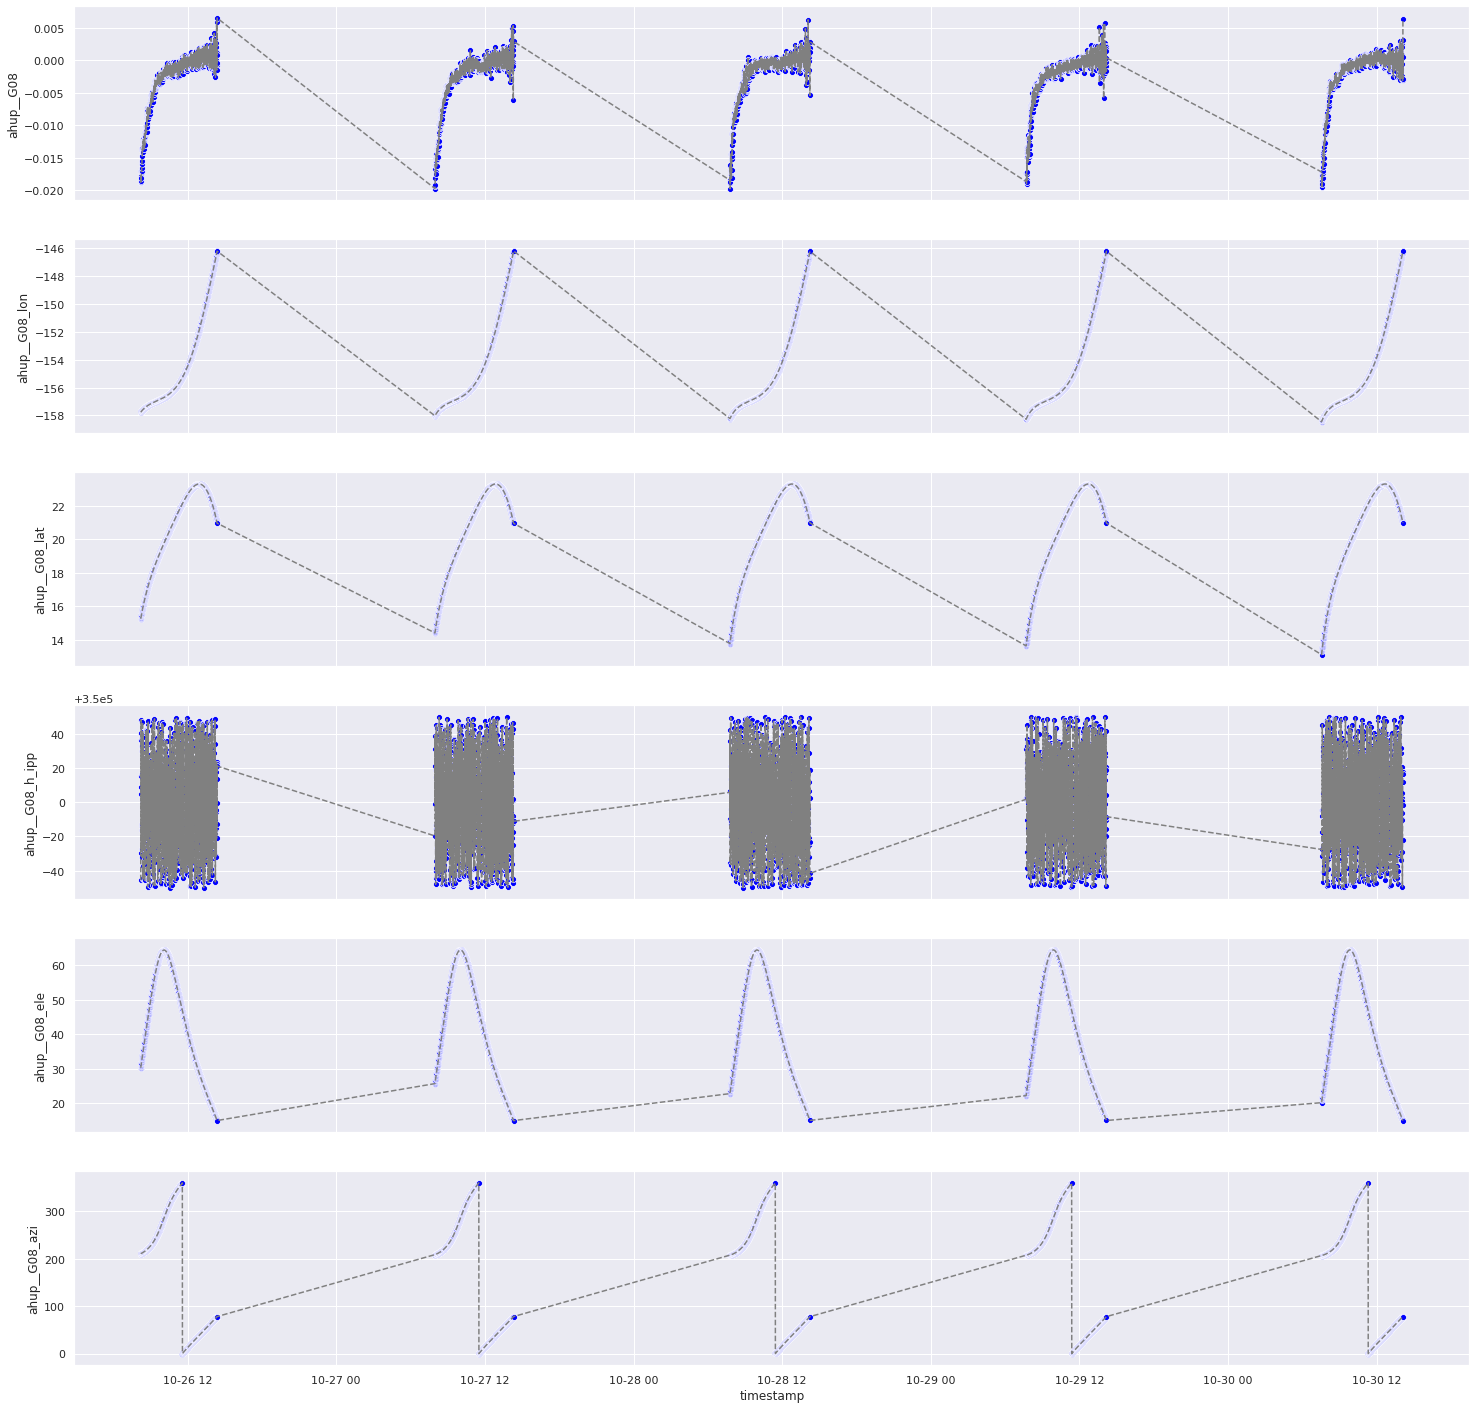

In [69]:
# create subplots that show the values in the data
values = list()
for val in df_sat:
    values.append(val)


sns.set(style="darkgrid")
f, axes = plt.subplots(len(values), 1, figsize=(25,25), sharex=True)
i = 0

for val in values:
    ax = sns.lineplot(x=df_sat.index, y=val, ax=axes[i], data=df_sat, color="gray")
    ax.lines[0].set_linestyle("--")
    
    ax2 = sns.scatterplot(x=df_sat.index, y=val,
                data=df_sat, ax=axes[i],
                color="blue")
    
    i += 1


plt.show()

#### For the Day of the Earthquake 

In [70]:
# get those dates from the 28th of the month, day of the earthquake
filter_index = df_sat.index.to_series().between('2012-10-28', '2012-10-28 23:59:00')

In [71]:
df_sat_earthquake = df_sat[filter_index]

In [72]:
df_sat_earthquake

ahup__G08  ahup__G08_lon  ahup__G08_lat  ahup__G08_h_ipp  \
timestamp                                                                       
2012-10-28 07:47:00  -0.018432    -158.223229      13.772430    350005.801263   
2012-10-28 07:47:30  -0.018791    -158.207316      13.821040    350042.347538   
2012-10-28 07:48:00  -0.019737    -158.190801      13.870737    349964.578594   
2012-10-28 07:48:30  -0.016308    -158.175549      13.917906    350035.678524   
2012-10-28 07:49:00  -0.018681    -158.159705      13.966145    349990.244485   
...                        ...            ...            ...              ...   
2012-10-28 14:12:30   0.001973    -146.358564      21.086982    349976.959909   
2012-10-28 14:13:00   0.001909    -146.320996      21.058693    350002.683044   
2012-10-28 14:13:30   0.001288    -146.283479      21.030141    350018.822989   
2012-10-28 14:14:00  -0.005411    -146.247552      21.001131    349955.831646   
2012-10-28 14:14:30   0.002815    -146.210193      20.972108    349958.422089   

                     ahup__G08_ele  ahup__G08_azi  
timestamp                                          
2012-10-28 07:47:00      22.838788     207.389142  
2012-10-28 07:47:30      23.048702     207.461047  
2012-10-28 07:48:00      23.258886     207.533838  
2012-10-28 07:48:30      23.469107     207.607557  
2012-10-28 07:49:00      23.679374     207.682206  
...                            ...            ...  
2012-10-28 14:12:30      15.375827      76.993961  
2012-10-28 14:13:00      15.298946      77.220777  
2012-10-28 14:13:30      15.221821      77.447667  
2012-10-28 14:14:00      15.144716      77.674366  
2012-10-28 14:14:30      15.067478      77.901023  

[776 rows x 6 columns]

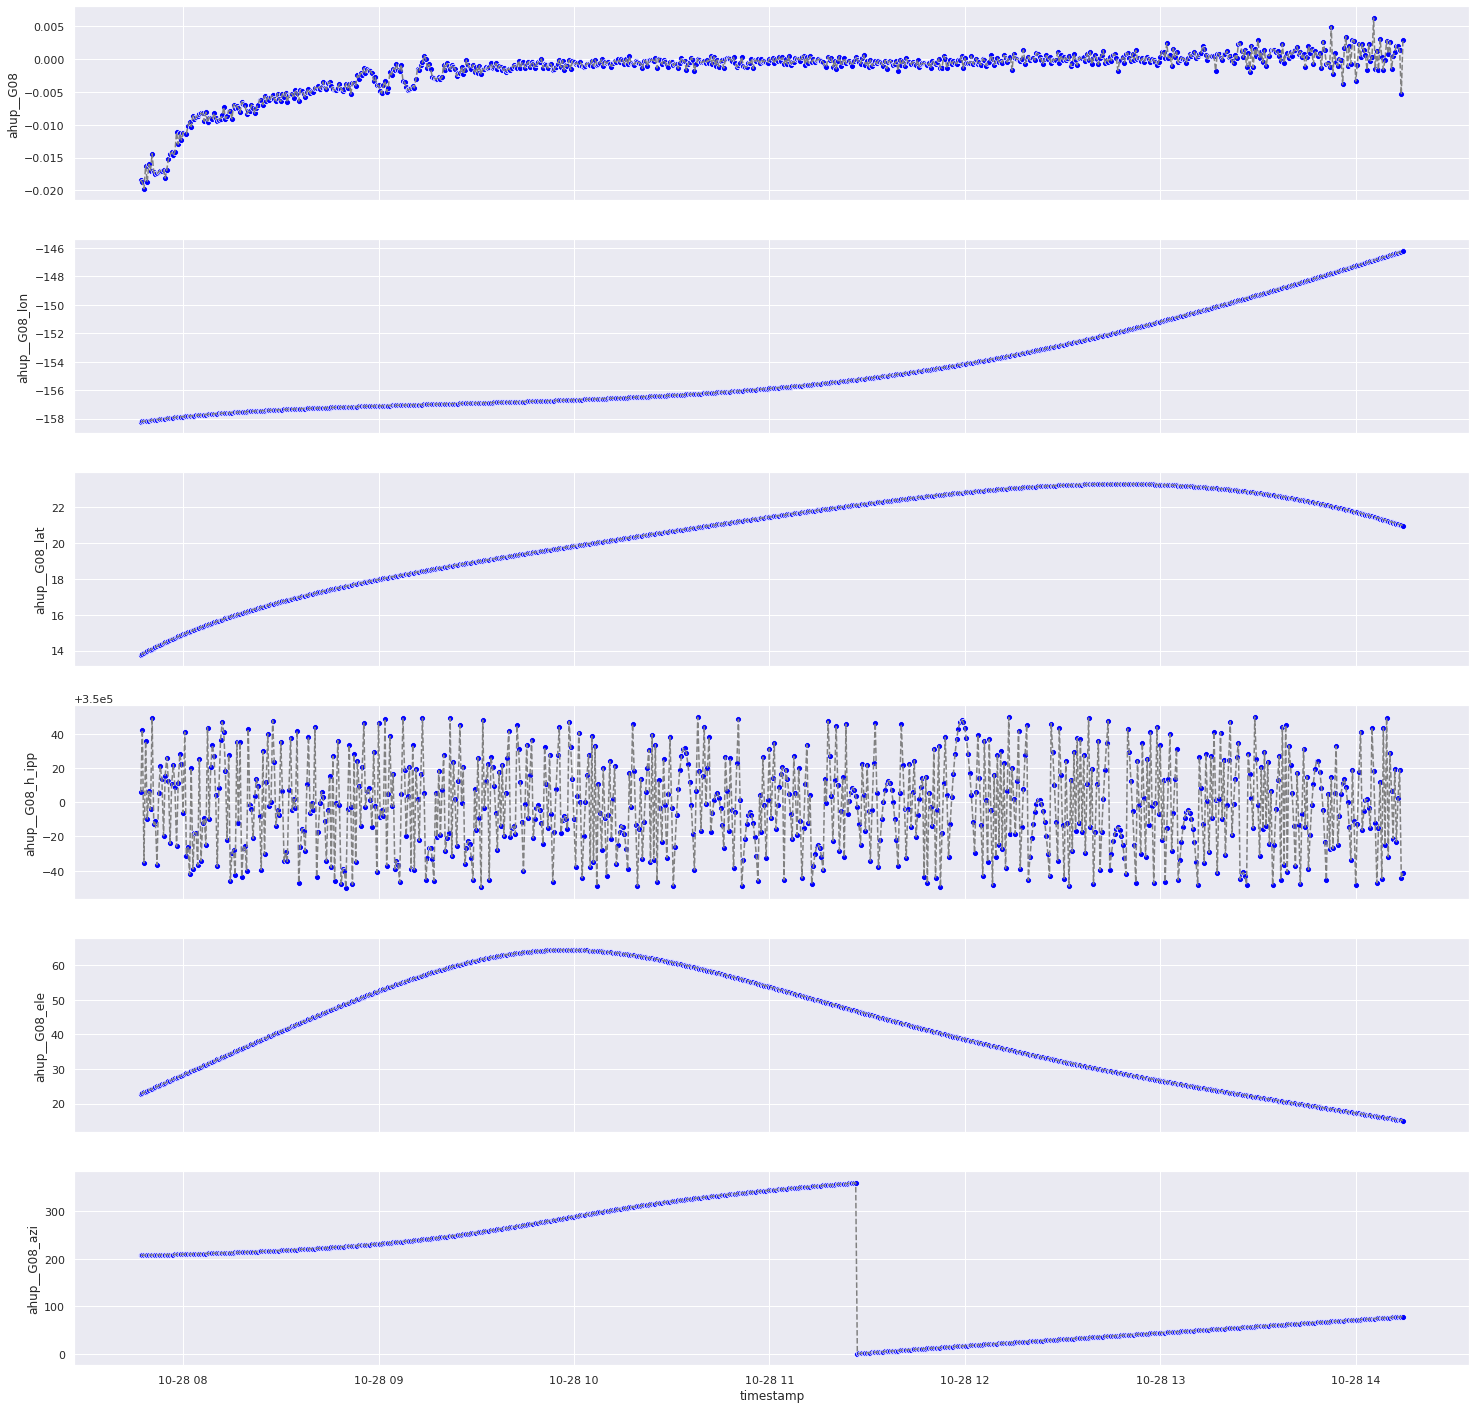

In [73]:
# create subplots similar to the paper
values = list()
for val in df_sat_earthquake:
    values.append(val)


sns.set(style="darkgrid")
f, axes = plt.subplots(len(values), 1, figsize=(25,25), sharex=True)
i = 0

for val in values:
    ax = sns.lineplot(x=df_sat_earthquake.index, y=val, ax=axes[i], data=df_sat_earthquake, color="gray")
    ax.lines[0].set_linestyle("--")
    
    ax2 = sns.scatterplot(x=df_sat_earthquake.index, y=val,
                data=df_sat_earthquake, ax=axes[i],
                color="blue")
    
    i += 1


plt.show()

### Split The Data Into Periods 

These periods are defined by consecutive empty (NaN) values in the dataframe. The data is only available for the satellite as it passes close to the ground station on each day. We will train the data in a similar way, ensuring our approach is compatible with the constraints in the operating environment. 

In [74]:
def split_dataframe(dataframe: pd.DataFrame) -> list: 

    # handle missing values and "chunk" the data for training and testing 
    events = np.split(dataframe, np.where(np.isnan(dataframe))[0])

    # removing NaN entries
    events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]

    # removing empty DataFrames
    events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

    return events

In [75]:
events = split_dataframe(df_model)
len(events)

5

In [76]:
events[1]

ahup__G08  ahup__G08_lon  ahup__G08_lat  ahup__G08_h_ipp  \
timestamp                                                                       
2012-10-27 07:58:00  -0.019539    -158.012679      14.428484    350000.814776   
2012-10-27 07:59:00  -0.018557    -157.986398      14.512802    350034.934827   
2012-10-27 08:00:00  -0.016366    -157.960494      14.596097    350018.929536   
2012-10-27 08:01:00  -0.017312    -157.934955      14.678380    349955.834126   
2012-10-27 08:02:00  -0.015886    -157.910708      14.757978    349992.084432   
...                        ...            ...            ...              ...   
2012-10-27 14:15:00   0.000264    -146.460835      21.162275    349976.908908   
2012-10-27 14:16:00   0.002376    -146.386128      21.106632    350022.397804   
2012-10-27 14:17:00  -0.002288    -146.313194      21.049777    349964.865072   
2012-10-27 14:18:00   0.001819    -146.238314      20.992331    349989.906889   
2012-10-27 14:19:00   0.002882    -146.182327      20.948628    349988.842915   

                     ahup__G08_ele  ahup__G08_azi  
timestamp                                          
2012-10-27 07:58:00      25.842273     208.510934  
2012-10-27 07:59:00      26.264460     208.682791  
2012-10-27 08:00:00      26.686681     208.858631  
2012-10-27 08:01:00      27.109096     209.038475  
2012-10-27 08:02:00      27.531767     209.222357  
...                            ...            ...  
2012-10-27 14:15:00      15.589480      76.379533  
2012-10-27 14:16:00      15.436001      76.833650  
2012-10-27 14:17:00      15.282130      77.287510  
2012-10-27 14:18:00      15.127960      77.740993  
2012-10-27 14:19:00      15.012008      78.080990  

[382 rows x 6 columns]

We know from domain knowledge that each period in the data corresponds to a specific day. The third day in the dataset (`302`) corresponds to the third period (index `2`) in the dataset. 

All of the experiments will attempt at detecting the anomaly using an analysis of the residual values using the day of the earthquake, which will be contained in the `validation` set. Data prior to the day of the earthquake, with the day prior to the earthquake being used for `test` data. Any days prior to that are considered as training data. 

At some point in the future, we will want to setup a controlled trail of how this would operate in practice (daily retraining of models). For now, we will focus on the task of training the model for the first time. 

### Scale the Data 

Deep learning models do not perform well when model inputs are not scaled appropriately. In this application, we will scale the data for each feature to a scale of -1 to 1, and do so separetely for each day. This is again driven by operational considerations. 

In [77]:
normalized_events = list()
for ev in events: 
    
    # for each column in the data, rescale -1 to 1 
    col_data = list()
    for col in ev.columns.values:
        
        normalized_data = minmax_scale(
                    ev[col].dropna(), 
                    feature_range=(-1, 1)
                )
        col_data.append(normalized_data)
        
    df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
    df_period["timestamp"] = ev[col].index
    df_period.index = df_period["timestamp"]
    df_period = df_period.drop(columns=["timestamp"])
    
    # convert to seconds of the day for later annotation 
    df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second
    
    normalized_events.append(df_period)


In [78]:
len(normalized_events)

5

In [79]:
normalized_events[2].shape

(388, 7)

In [80]:
normalized_events[0]

ahup__G08  ahup__G08_lon  ahup__G08_lat  ahup__G08_h_ipp  \
timestamp                                                                       
2012-10-26 08:13:00  -1.000000      -1.000000      -1.000000        -0.440178   
2012-10-26 08:14:00  -0.996421      -0.996611      -0.982845         0.900296   
2012-10-26 08:15:00  -0.966263      -0.993224      -0.965781         0.597841   
2012-10-26 08:16:00  -0.923276      -0.989893      -0.948938        -0.227936   
2012-10-26 08:17:00  -0.879768      -0.986728      -0.932573         0.669278   
...                        ...            ...            ...              ...   
2012-10-26 14:19:00   0.568410       0.951832       0.469699        -0.159152   
2012-10-26 14:20:00   0.687798       0.964624       0.455824         0.108497   
2012-10-26 14:21:00   0.466836       0.977367       0.441711        -0.234405   
2012-10-26 14:22:00   0.498402       0.990318       0.427417         0.379626   
2012-10-26 14:23:00   1.000000       1.000000       0.416546         0.448975   

                     ahup__G08_ele  ahup__G08_azi    sod  
timestamp                                                 
2012-10-26 08:13:00      -0.376661       0.170632  29580  
2012-10-26 08:14:00      -0.359557       0.171843  29640  
2012-10-26 08:15:00      -0.342455       0.173080  29700  
2012-10-26 08:16:00      -0.325355       0.174341  29760  
2012-10-26 08:17:00      -0.308262       0.175629  29820  
...                            ...            ...    ...  
2012-10-26 14:19:00      -0.976651      -0.576462  51540  
2012-10-26 14:20:00      -0.982858      -0.573935  51600  
2012-10-26 14:21:00      -0.989078      -0.571410  51660  
2012-10-26 14:22:00      -0.995314      -0.568886  51720  
2012-10-26 14:23:00      -1.000000      -0.566995  51780  

[371 rows x 7 columns]

### Allocate Data for Modeling

In [81]:
def allocate_periods(periods: list, index_earthquake: int) -> dict:
    
    data = dict()
    
    data["valid"] = periods[index_earthquake]
    data["test"] = periods[index_earthquake - 1]
    data["train"] = periods[0:index_earthquake - 1]
    
    return data

In [82]:
df_model_by_period = allocate_periods(normalized_events, 2)

## Train the Model 

In [83]:
print(len(df_model_by_period["train"]))

1


The below function preps the data for modeling in Fast AI. 

In [84]:
## Work in progress
def make_dataBunch(df_train: pd.DataFrame, df_test: pd.DataFrame, df_valid: pd.DataFrame, features: list, dependent: str, include_catvars: bool = False, catvars: list = [], batch_size: int = 256):
    """
    Creates a TabularDataBunch to feed as an input 
    into the learner. 
    """
    
    valid_start_index = df_train.shape[0] + 1
    valid_end_index = df_train.shape[0] + df_test.shape[0]
    
    df_train_validation = pd.concat([df_train, df_test])
        
    # create the data bunch
    if include_catvars:
        data = TabularDataBunch.from_df(
            "models", 
            df_train_validation[features + [dependent]], 
            dependent, 
            valid_idx=np.array(list(range(valid_start_index, valid_end_index))),
#             test_df=df_test, 
            procs=[Categorify],
            bs=batch_size, # batch size
            cat_names=catvars,
            device=cuda_device,
            num_workers=0
        )
    else:
        data = TabularDataBunch.from_df(
            "models", 
            df_train_validation[features + [dependent]], 
            dependent, 
            valid_idx=np.array(list(range(valid_start_index, valid_end_index))),
#             test_df=df_test, 
            procs=None, # disable any automatic preprocessing
            bs=batch_size, # batch size
            device=cuda_device,
            num_workers=0
        )
 
    return {
        "databunch": data, 
        "train": df_train, 
        "test": df_test, 
        "valid": df_valid
    }

### Determine the Learning Rate

We utilize an [automatic learning rate finder](https://forums.fast.ai/t/automated-learning-rate-suggester/44199/8) to determine the ideal learning rate automatically. While this approach does not always guarantee that the perfect learning rate is found, in practice we have found the approach to work well and has been quite stable.

In [85]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find(
        end_lr=2.,
        stop_div=False # continues through all LRs as opposed to auto stopping
    )
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

We will train the model for each day in the training set. 

### Time Series Cross Validation

Time-Series CV results will be tracked. Will contain the following: 

- `root_mean_square_error`
- `period`
- `learn_rate` 


---------- PERIOD: 0 ----------
Learning rate: 0.001


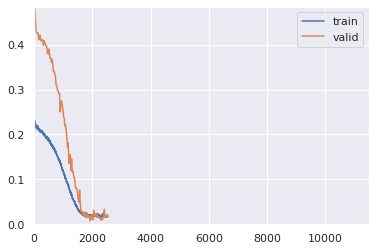

Epoch 109: early stopping


In [ ]:
time_series_cv_log = list()
cv_log_cols = ["root_mean_square_error", "period", "learn_rate"]

lr = None
for i in range(0, len(df_model_by_period["train"])):
    
    print("\n---------- PERIOD: " + str(i) + " ----------")
    
    # TODO: TEST THE BELOW
    # if this isn't the first time a model is trained, load it from memory 
    if i != 0:
        # load learner
        lr = tabular_learner().load('model-latest') 
    
    # first, create a data bunch for this round of the modeling process        
    df_train = df_model_by_period["train"][i]
    df_train[DEP + "_target"] = df_train[DEP]
    df_test = df_model_by_period["test"]
    df_test[DEP + "_target"] = df_test[DEP]
    df_valid = df_model_by_period["valid"]
    df_valid[DEP + "_target"] = df_valid[DEP]
    
    data_bunch = make_dataBunch(
        df_train, 
        df_test,
        df_valid,
        FEATURES, 
        DEP + "_target", 
        include_catvars=False, 
        catvars=None, 
        batch_size=BATCH_SIZE
    )
    
    # define the model 
    if lr is None: 
        lr = tabular_learner(
            data_bunch["databunch"], 
            layers=architectures[MODEL_ARCHITECTURE]["layers"], 
            ps=architectures[MODEL_ARCHITECTURE]["ps"],
            metrics=[root_mean_squared_error], 
            callback_fns=[CSVLogger, PeakMemMetric]
        )
        
#     # automatically find the ideal learning rate 
#     try:
#         learn_rate = find_appropriate_lr(
#             model=lr,
#             plot=True
#         )
        
#     except:
#         learn_rate = 0.001
#         print("ERROR: cannot determine learning rate.")
    
    learn_rate = 0.001
    
    print("Learning rate: " + str(learn_rate))
          
    # train the model 
    lr.fit_one_cycle(
        MAX_EPOCHS, # max epocjh
        learn_rate,
        callbacks=[
            SaveModelCallback(
                lr, 
                every='epoch', 
                monitor=['accuracy', 'root_mean_square_error']
            ),
            EarlyStoppingCallback(
                lr,
                monitor='valid_loss', #'valid_loss', 'root_mean_square_error'
                min_delta=0.0001, # 0.0001
                patience=25
            ),
            ShowGraph(
                lr
            )
        ]
    )
          
    # loaded learners do not have a recorder
    lr.recorder.plot_losses()
    lr.recorder.plot_metrics()

    rmse = lr.recorder.metrics[0][0].item()
#     r2_score = lr.recorder.metrics[0][1]
    
    time_series_cv_log.append(
        [rmse, i, learn_rate]
    )
    
    # save learner and export the model weights
    lr.save(MODEL_LOCATION)
    lr.export(MODEL_LOCATION + '-export.pkl')
        
print("Results from last training set.")
print(lr.show_results())
   
time_series_cv_results_df = pd.DataFrame(
    time_series_cv_log,
    columns=cv_log_cols
)               

In [101]:
time_series_cv_results_df

root_mean_square_error  period  learn_rate
0                0.668203       0       0.001

Note that the above training process is specific to a satellite and ground station. In order to report many of the metrics below, we will need to (at a later date) perform the training and testing process over multiple satellite and ground station combinations. 

Now that the model training is complete, load the learner from disk. 

In [102]:
# # load learner
# lr = lr.load('model-latest') 

In [103]:
# show me a summary look at the results 
lr.show_results()

Plot the values on the testing set used for model training. 

In [104]:
# function to predict values using input data from new data

def predict_values(dataframe, learner, dependent, frac=1.0):
    
    """
    Using the passed learner, predicts the appropriate value given the input data 
    and generates errors for analysis. 
    """
    
    # get a sample of the dataset 
    dataframe_pred = dataframe.copy()
    n_obs = int(dataframe_pred.shape[0] * frac)
    idx = random.sample(range(0, dataframe_pred.shape[0]), n_obs)
    dataframe_pred = dataframe_pred.iloc[idx, :]
    
    # get the predictions
    
    # TODO: update this to work with gpu over large samples like the other function 
    predictions = []
    print('Generating predictions and errors...')
    for idx, row in tqdm(dataframe_pred.iterrows(), total=dataframe_pred.shape[0]):        
        predictions.append(learner.predict(row)[1].numpy()[0])
    
    
    dataframe_pred["predicted"] = predictions
    dataframe_pred['error'] = dataframe_pred['predicted'] - dataframe_pred[dependent]
    dataframe_pred['absolute_error'] = np.abs(dataframe_pred['error'])
    dataframe_pred["timestamp"] = dataframe_pred.index
    
    return dataframe_pred
    

Generate a dataframe from the predicted values on the `test` set. 

In [105]:
df_test = predict_values(
    dataframe=data_bunch["test"], # TODO: currently using latest databunch from prev loop
    learner=lr, # TODO: currently using latest learner from prev loop
    dependent=DEP + "_target",
    frac=1.
).sort_index()

Generating predictions and errors...


Plot the predicted (blue) versus the actual (gray) values. 

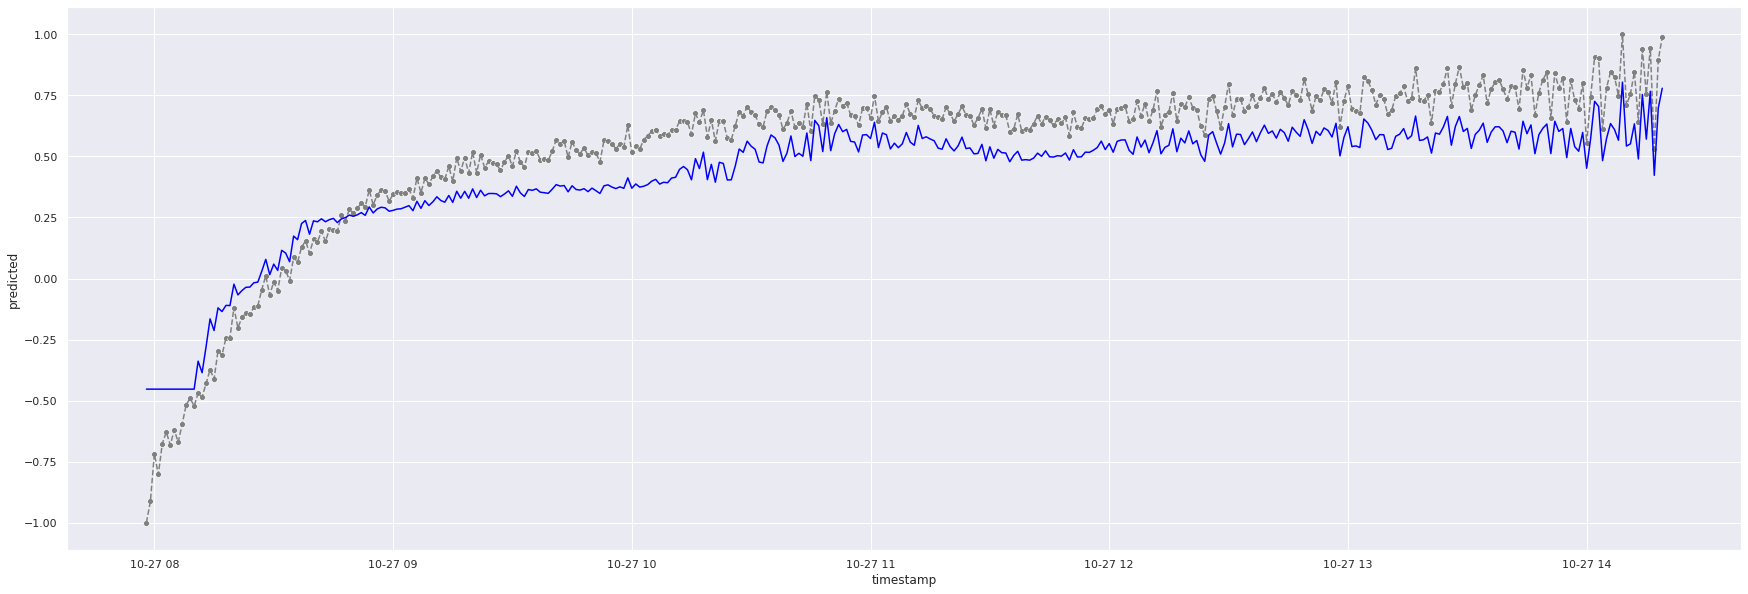

In [106]:
plt.figure(figsize=(30, 10))

ax = sns.lineplot(x=df_test.index, y=DEP + "_target", data=df_test, color="gray")
ax.lines[0].set_linestyle("--")

ax2 = sns.scatterplot(x=df_test.index, y=DEP + "_target",
            data=df_test,
            color="gray")


ax3 = sns.lineplot(x=df_test.index, y="predicted", data=df_test, color="blue")

plt.show()

Plot the absolute error. 

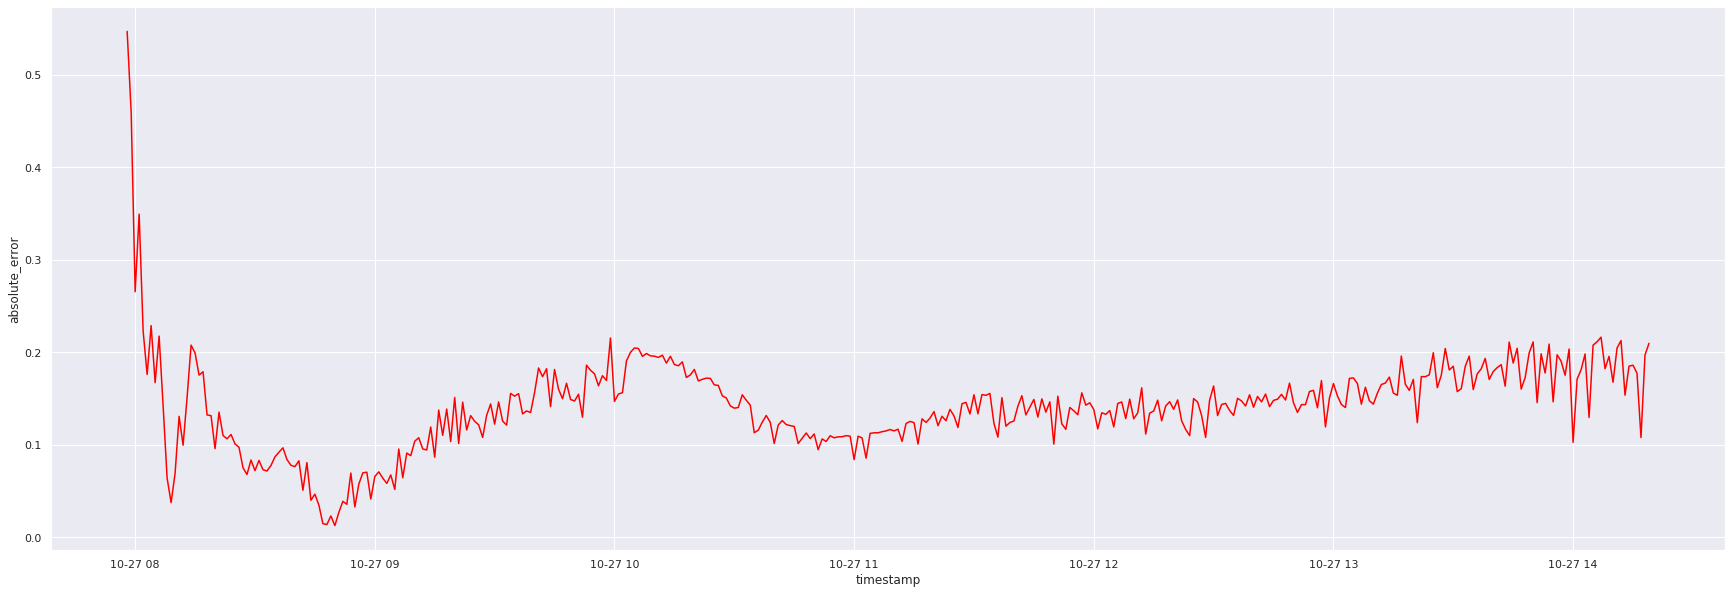

In [107]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_test.index, y="absolute_error", data=df_test, color="red")
# ax.lines[0].set_linestyle("--")

# ax2 = sns.scatterplot(x=df_assess_day.index, y="absolute_error",
#             data=df_assess_day,
#             color="darkgray")

plt.show()

## Identify and Classify Tsunami-Related Disturbances

Using the validation data - the day of the earthquake - use the residuals to detect the anomaly. 

This section is a **work in progress**. In order to estimate the model's `accuracy`, `recall`, `precision`, `F-score`, and `coverage`, we need to be able to classify specific time periods as anomalous - in this context, as ionoshperic disturbances related to tsunami waves. 

In [108]:
df_assess = predict_values(
    dataframe=data_bunch["valid"], # TODO: currently using latest databunch from prev loop
    learner=lr, # TODO: currently using latest learner from prev loop
    dependent=DEP + "_target",
    frac=1.
).sort_index()

Generating predictions and errors...


In [109]:
df_assess.sample(frac=1).head()

ahup__G08  ahup__G08_lon  ahup__G08_lat  ahup__G08_h_ipp  \
timestamp                                                                       
2012-10-28 09:52:00   0.603013      -0.755253       0.224694         0.116869   
2012-10-28 11:32:00   0.656724      -0.481267       0.780616         0.722351   
2012-10-28 09:39:00   0.533501      -0.771365       0.145188         0.319729   
2012-10-28 13:45:00   0.804132       0.656508       0.796710        -0.282252   
2012-10-28 11:12:00   0.692056      -0.568098       0.678581        -0.106761   

                     ahup__G08_ele  ahup__G08_azi    sod  ahup__G08_target  \
timestamp                                                                    
2012-10-28 09:52:00       0.995117       0.554370  35520          0.603013   
2012-10-28 11:32:00       0.225520      -0.985422  41520          0.656724   
2012-10-28 09:39:00       0.943794       0.471394  34740          0.533501   
2012-10-28 13:45:00      -0.822484      -0.642715  49500          0.804132   
2012-10-28 11:12:00       0.436534       0.956425  40320          0.692056   

                     predicted     error  absolute_error           timestamp  
timestamp                                                                     
2012-10-28 09:52:00   0.397840 -0.205172        0.205172 2012-10-28 09:52:00  
2012-10-28 11:32:00   0.534897 -0.121827        0.121827 2012-10-28 11:32:00  
2012-10-28 09:39:00   0.366979 -0.166522        0.166522 2012-10-28 09:39:00  
2012-10-28 13:45:00   0.615047 -0.189085        0.189085 2012-10-28 13:45:00  
2012-10-28 11:12:00   0.556066 -0.135990        0.135990 2012-10-28 11:12:00

### Plot Actual and Predicted Values

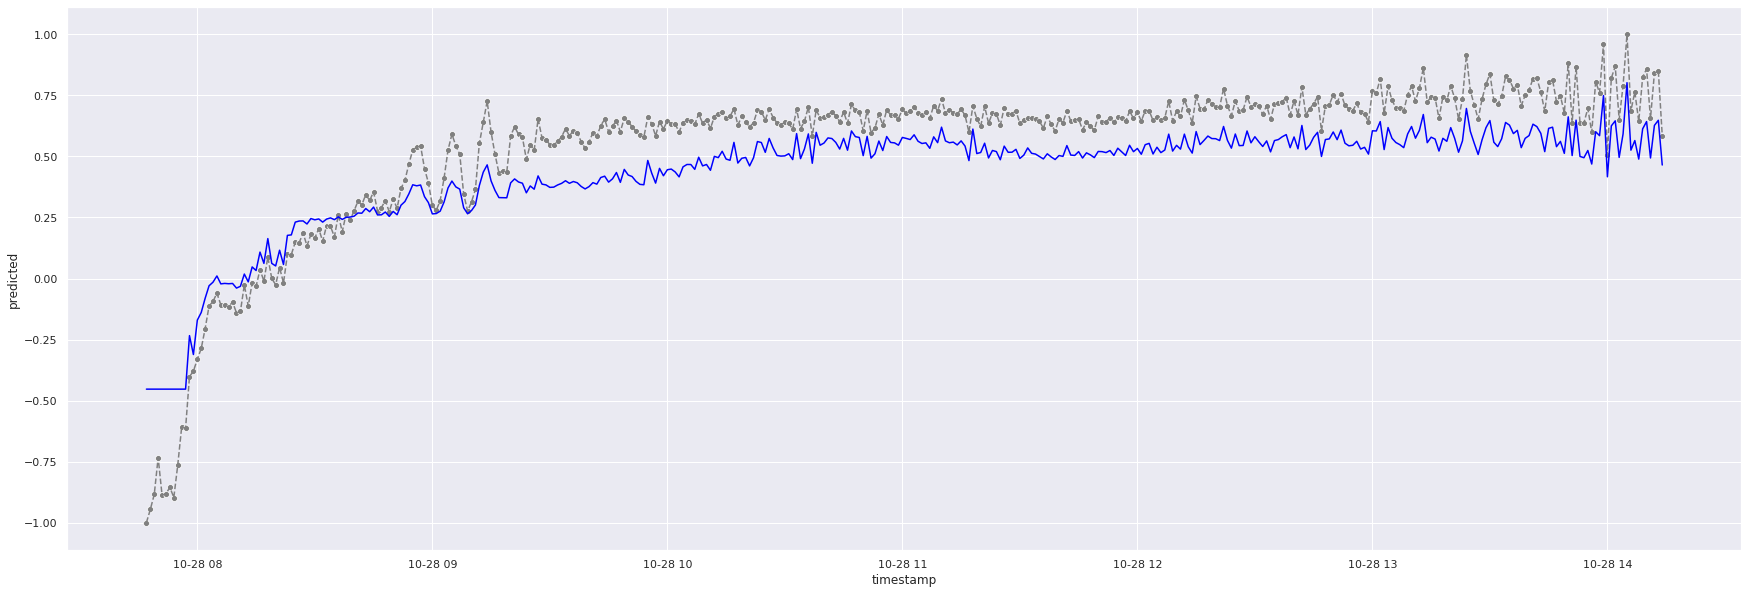

In [110]:
plt.figure(figsize=(30, 10))

ax = sns.lineplot(x=df_assess.index, y=DEP + "_target", data=df_assess, color="gray")
ax.lines[0].set_linestyle("--")

ax2 = sns.scatterplot(x=df_assess.index, y=DEP + "_target",
            data=df_assess,
            color="gray")


ax3 = sns.lineplot(x=df_assess.index, y="predicted", data=df_assess, color="blue")

plt.show()

### Plot the Absolute Error 

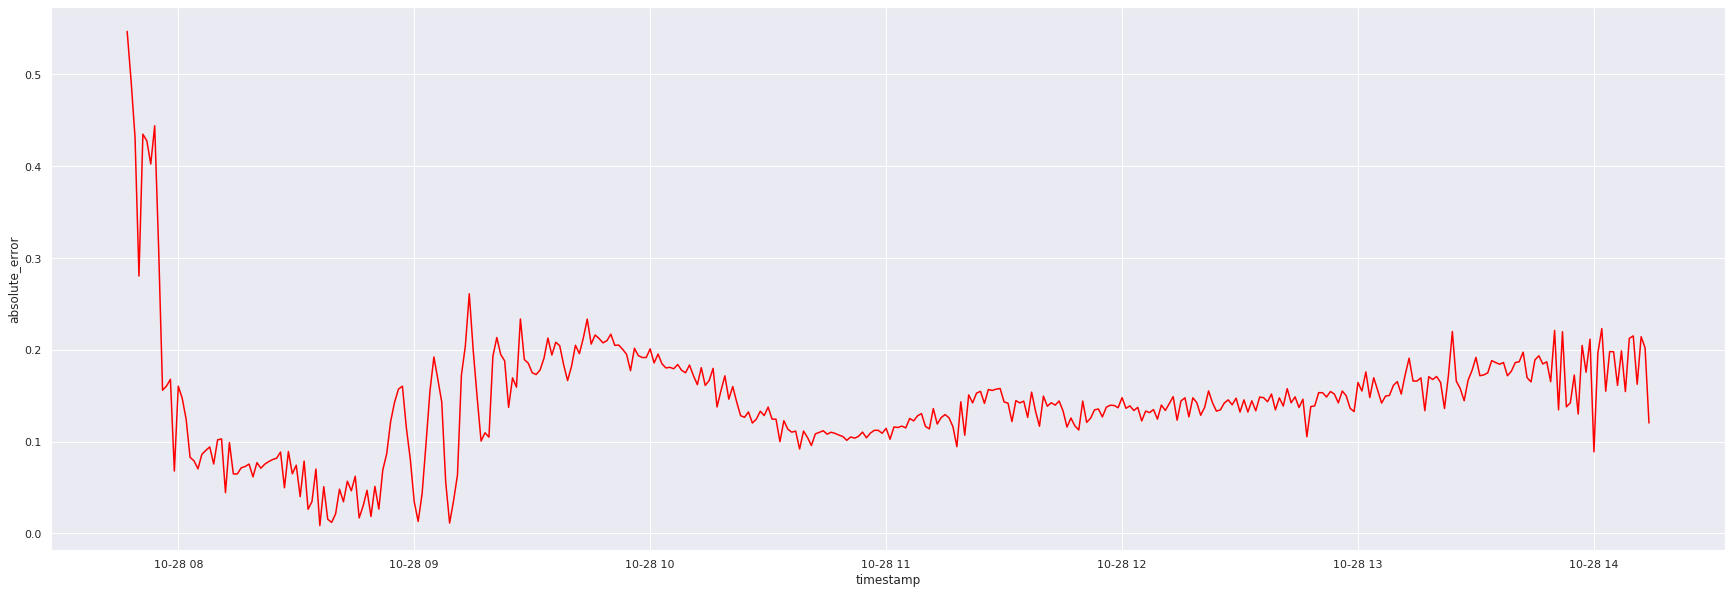

In [111]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_assess.index, y="absolute_error", data=df_assess, color="red")
# ax.lines[0].set_linestyle("--")

# ax2 = sns.scatterplot(x=df_assess_day.index, y="absolute_error",
#             data=df_assess_day,
#             color="darkgray")

plt.show()

If we see a spike in the residual values at the approximate time of the tsunami-wave, we can use that information to explore ways of automating the detection of these disturbances. The approach to utilize for this classification is explored in the following sections. 

It should be noted that the ability to detect these disturbances must be thoroughly tested across multiple satellites and ground stations. 

### Classify Time Periods As Anomalous

Model performance will generally always be impacted towards the start of a period (day) due to having less available data (data less than the specified batch size) for making predictions. This impacts model performance (confidence) at the start of any period, and thus confidence in the model will be less at early stages (until about an hour of data is collected). 

Once the event occurs, it seems to represent a large-enough deviation from the previous day(s) (used for model training) to result in elevated absolute errors for each prediction by the model after the change begins to occur in the the TEC variation. We can use this emperical finding to create a method for detection. 

We will not be able to do any better than an on-time detection of the event (meaning, there will be some lag between the start of the event and the detection of the event). We can score the approach and generate metrics (described further below) based on some specified threshold of acceptability of detection, e.g. 5 minutes (or something else). 

In [112]:
# definition of start times for tsunami-wave induced pertubations by satellite
# start time defined by second in day 
sod_annotations = {
    "G04": 31400,
    "G07": 31160,
    "G08": 31900,
    "G10": 29900,
    "G20": 31150
}

Let's create an improved version of an earlier plot showing absolute errors that highlights the period of increased model confidence / performance at the start of the period and also has a vertical line indicating the start time of the pertubation in TEC variation. This plot will also show the time period in which we classify as anomalous. 

In [113]:
sod_annotations

{'G04': 31400, 'G07': 31160, 'G08': 31900, 'G10': 29900, 'G20': 31150}

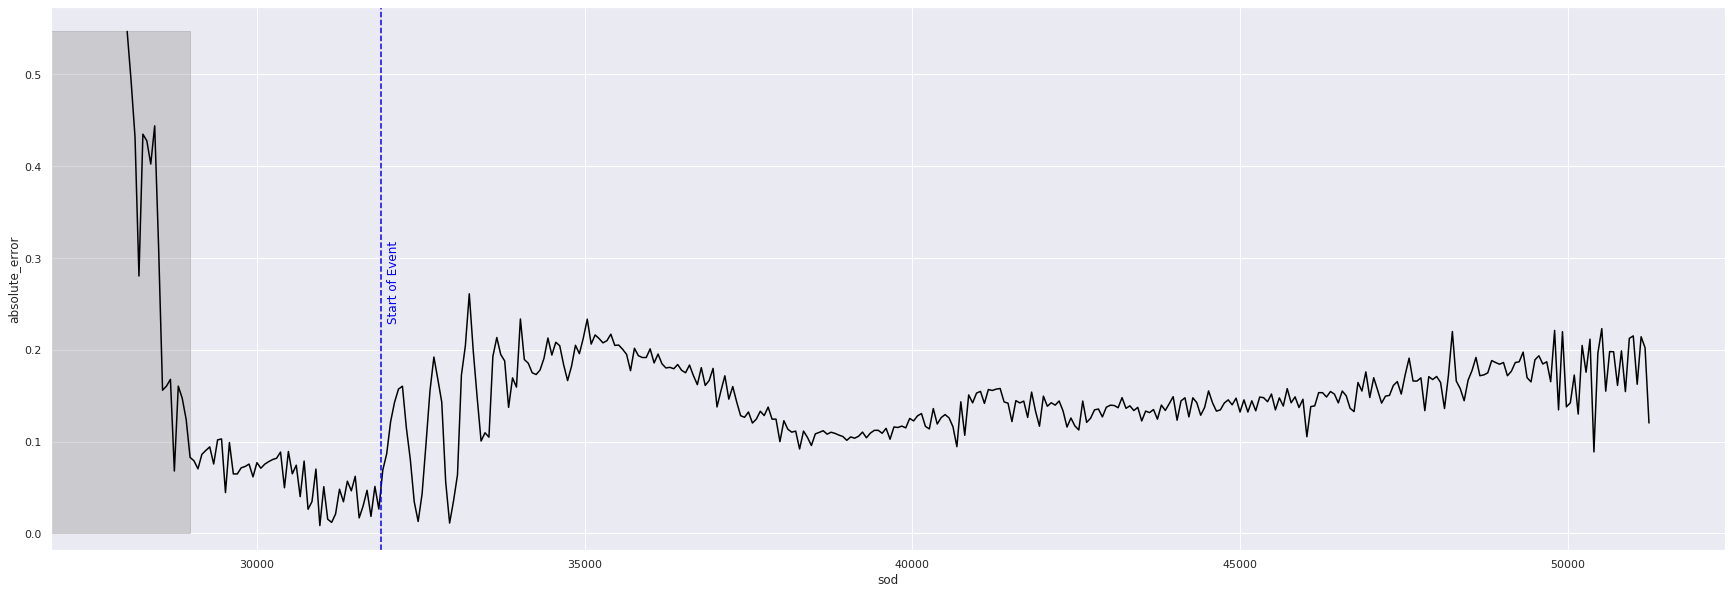

In [120]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_assess["sod"], y="absolute_error", data=df_assess, color="black")
ax.axvline(sod_annotations[SAT], color="blue", linestyle="--")
plt.text(sod_annotations[SAT] + 80, np.max(df_assess["absolute_error"].values) / 2, "Start of Event", rotation=90, verticalalignment='center', color="blue")
ax.add_patch(
    patches.Rectangle(
        (0, 0), 
        df_assess.iloc[BATCH_SIZE]["sod"],
        np.max(df_assess["absolute_error"].values),
        color="gray",
        alpha=0.3
    )
)


# ax2 = sns.lineplot(x=df_assess["sod"], y="absolute_error", data=df_assess, color="black")

plt.show()

Goal to develop approach of handling residual values for detection. 

In [121]:
# mean of abs errors 
np.mean(df_assess["absolute_error"])

0.14501216660786967

In [122]:
# standard devation
np.std(df_assess["absolute_error"])

0.06354025573757888

#### Distribution of Errors 

A lot of error handling approaches and work assume that the errors have Gaussian distributions. Let's visualize the distribution of values and do a formal test for normality. If we find that the distribution of errors is generally normal, we could use approaches that are suitable for that type of data distribution. If not, we should look at other approaches for handling the model errors. 

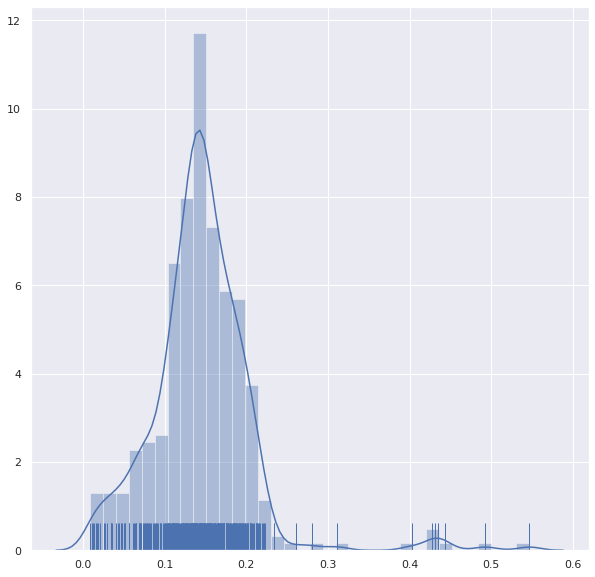

In [222]:
# distribution of the errors
plt.figure(figsize=(10, 10))
sns.distplot(df_assess["absolute_error"].values, kde=True, rug=True);
plt.show()

Let's plot a QQ plot. This will provide a visual indication as to the normality of the data. If the points closely follow the diagonal line, then they closely fit the pattern we would expect from a Gaussian distribution. 

In [226]:
qq = stats.probplot(df_assess["absolute_error"].values, dist='lognorm', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])

fig = go.Figure()
fig.add_scatter(x=qq[0][0], y=qq[0][1], mode='markers')
fig.add_scatter(x=x, y=qq[1][1] + qq[1][0]*x, mode='lines')
fig.layout.update(showlegend=False)
fig.show()

#### Normality Tests

In [227]:
# Shapiro normality test
stat, p = stats.shapiro(df_assess["absolute_error"].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.843, p=0.000
Sample does not look Gaussian (reject H0)


In [229]:
# D’Agostino’s K^2  normality test
stat, p = stats.normaltest(df_assess["absolute_error"].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=195.531, p=0.000
Sample does not look Gaussian (reject H0)


In [230]:
# Anderson-Darling normality test
result = stats.anderson(df_assess["absolute_error"].values)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 9.395
15.000: 0.570, data does not look normal (reject H0)
10.000: 0.649, data does not look normal (reject H0)
5.000: 0.779, data does not look normal (reject H0)
2.500: 0.909, data does not look normal (reject H0)
1.000: 1.081, data does not look normal (reject H0)


Playing around! 

In [123]:
import rrcf

In [128]:
# create tree 
# tree = rrcf.RCTree()

In [210]:
# insert data 
abs_err_vals = df_assess["absolute_error"].values
# for i in range(0, abs_err_vals.shape[0]):
#     tree.insert_point(abs_err_vals[i], index=i)
n = abs_err_vals.shape[0]
tree_size = n
num_trees = 5000

In [211]:
# Construct forest
forest = []
pbar = tqdm(total=num_trees)
while len(forest) < num_trees:
        
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(n, size=(n // tree_size, tree_size),
                           replace=False)
    # Add sampled trees to forest
#     trees = list()
    for ix in ixs:
        tree = rrcf.RCTree()
        for i in range(0, abs_err_vals[ix].shape[0]):
            tree.insert_point(abs_err_vals[ix][i], index=i)
        forest.append(tree)
        
    pbar.update(1)
    
#     forest.append(trees)

In [212]:
len(forest)

5000

In [213]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    
#     print("A")
    
#     print(tree.leaves)
    
#     print("tree")
    
    series_data = dict()
    for leaf in tree.leaves:
        series_data[leaf] = tree.codisp(leaf)
    
    codisp = pd.Series(series_data)
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [214]:
for i in avg_codisp:
    print(i)

11.688510653796945
11.807217329733195
10.73161023823383
9.543046610799083
9.212438197347703
9.205890958559488
9.031342031354601
8.771926510801025
8.599328988324993
8.879911955078644
8.249966892433578
8.788347483860539
8.166350756037687
8.586240877817268
8.142257233838325
8.322569435241409
7.592172637389669
8.30286201072336
7.733335022342398
7.765931705930113
8.132657886873725
7.858944538264597
7.622446184617656
7.6498903625168895
7.7680282109972945
8.144862863073994
7.745897197205908
8.146583909958212
7.606498102284798
7.426999591871673
7.312431804807825
7.799707454903182
7.7707899764017
7.658742102940924
7.8315304765149
7.447348141206993
7.3567868801578316
7.494280624414665
7.5475782232968704
7.719790099001735
7.6393633314532785
7.647871867689784
7.571337462738392
7.296656868989441
7.694497075255095
7.442146514807463
7.581055520496768
7.212873367766303
7.241251335201408
7.411253076200186
7.682856420551638
6.975880521700553
7.1526792006888735
7.602513279605372
6.9792874079837635
7.2224

In [215]:
df_assess["avg_codisp"] = avg_codisp.values

In [216]:
df_assess["avg_codisp"]

timestamp
2012-10-28 07:47:00    11.688511
2012-10-28 07:48:00    11.807217
2012-10-28 07:49:00    10.731610
2012-10-28 07:50:00     9.543047
2012-10-28 07:51:00     9.212438
                         ...    
2012-10-28 14:10:00     6.719662
2012-10-28 14:11:00     6.588018
2012-10-28 14:12:00     6.664512
2012-10-28 14:13:00     6.639383
2012-10-28 14:14:00     6.419797
Name: avg_codisp, Length: 388, dtype: float64

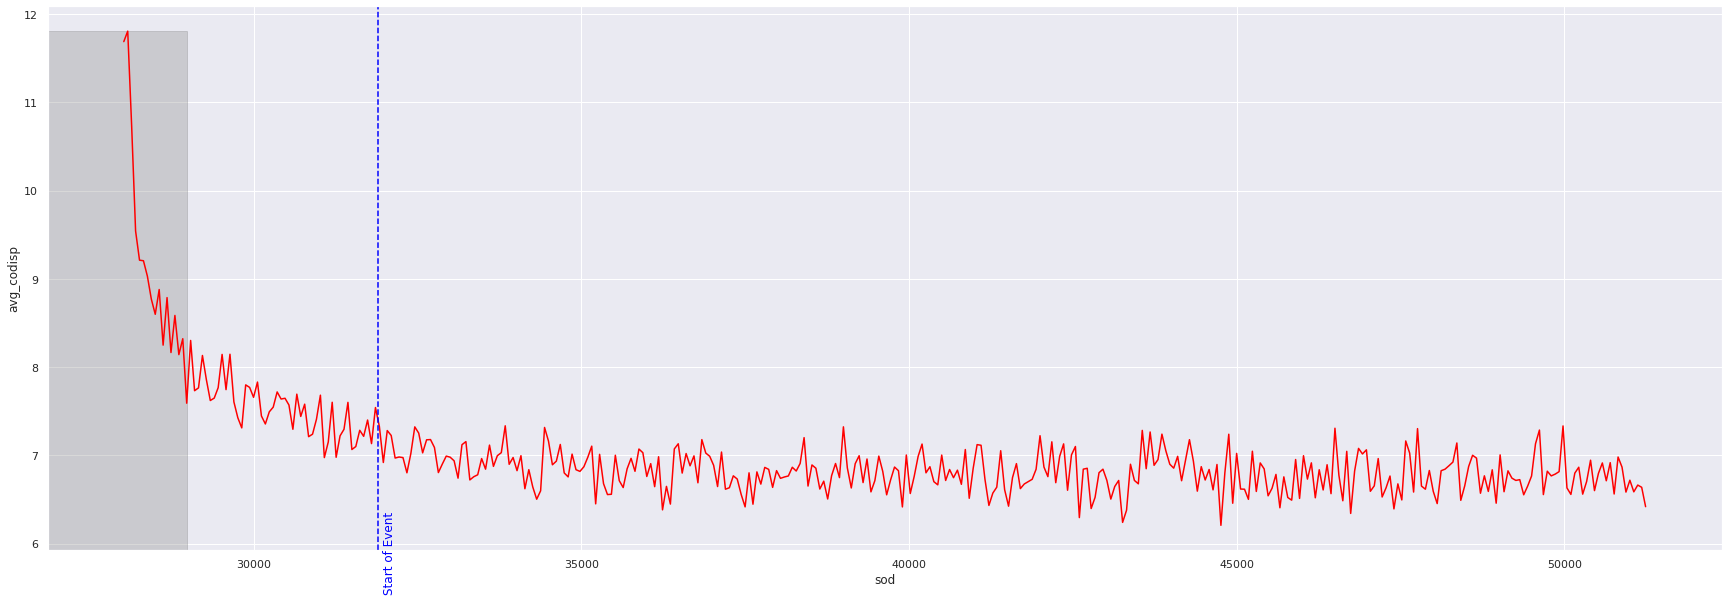

In [217]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_assess["sod"], y="avg_codisp", data=df_assess, color="red")
ax.axvline(sod_annotations[SAT], color="blue", linestyle="--")
plt.text(sod_annotations[SAT] + 80, np.max(df_assess["avg_codisp"].values) / 2, "Start of Event", rotation=90, verticalalignment='center', color="blue")
ax.add_patch(
    patches.Rectangle(
        (0, 0), 
        df_assess.iloc[BATCH_SIZE]["sod"],
        np.max(df_assess["avg_codisp"].values),
        color="gray",
        alpha=0.3
    )
)

plt.show()

## Assess Model and Approach to Classification

We need to report the following metrics: 

- **Root Mean Square Error**: measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed
- **Accuracy**: the number of correct classifications over the number of observations
- **Recall**: fraction of true events that were detected
- **Precision**: fraction of detections reported  by the model that are correct
- **F-Score**: the harmonic mean of the precision and recall, `2pr / (p + r)`
- **Coverage**: fraction of examples for which the system is able to produce a confident classification